In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import torch
import os
import time
from torch.utils import data
from d2l import torch as d2l
from torch import nn
from matplotlib import pyplot as plt

# # 设置中文和'-'负号显示问题
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['FangSong']  # 设置matplotlib可以显示汉语
# mpl.rcParams['axes.unicode_minus'] = False


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
# 数据初始化
# true_w = torch.tensor([2, -3.4])
# true_b = 4.2
# features, labels = d2l.synthetic_data(true_w, true_b, 1000)
# 3, 6, 7, 8
cols = ["One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Rect", "Time_ns"]
train_data = pd.read_csv("./dataset/0x01_300s.csv", header=None)
test_data = pd.read_csv("./dataset/0x01_50s.csv", header=None)
train_data.columns = test_data.columns = cols

In [4]:
# train_data.shape  # 查看数据的形状
# train_data.head() # 查看数据本身
# train_data.info() # 数据集的简单描述， 总行数，空值或者数据类型等
# train_data.value_counts() # 分类的时候用的多，查看类别的个数
# train_data.describe() # 简单的统计性表述，最大值，最小，平均等
# train_data.corr(method='pearson') # 查看列之间的相关性
# train_data.skew()  # 通过分析数据的高斯分布来确认数据的偏离情况

In [5]:
train_features = torch.tensor(train_data.drop(['Rect', 'Time_ns'], axis=1).values, dtype=torch.float32, device = device, requires_grad=True)
train_labels = torch.tensor(train_data.Rect.values.reshape(-1,1), dtype=torch.float32, device = device, requires_grad=True)

test_features = torch.tensor(test_data.drop(['Rect', 'Time_ns'], axis=1).values, dtype=torch.float32, device = device, requires_grad=True)
test_labels = torch.tensor(test_data.Rect.values.reshape(-1,1), dtype=torch.float32, device = device, requires_grad=True)

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

(torch.Size([14938, 8]),
 torch.Size([14938, 1]),
 torch.Size([2470, 8]),
 torch.Size([2470, 1]))

In [1]:
# #d2l.set_figsize()
# #d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

# plt.figure(figsize=(15,6), dpi=450)
# for plt_index in range(1,9):
#     plt.subplot(2, 4, plt_index)
#     plt.xlabel("通道" + str(plt_index))
#     plt.ylabel("幅度值")
#     # plt.scatter(train_features[:, plt_index - 1].detach().numpy(), train_labels.detach().numpy(), 1)
#     plt.scatter(test_features[:, plt_index - 1].detach().numpy(), test_labels.detach().numpy(), 1)
    
# plt.show()

In [7]:
# 定义网络
loss = nn.MSELoss()
in_features = train_features.shape[1]
out_features = 1
print(in_features, out_features)
def get_net():
    net = nn.Sequential(nn.Linear(in_features, out_features))
    return net

8 1


In [8]:
# 训练
def train(net, train_features, train_labels, test_features, test_labels,
            num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    tic = time.time()
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这⾥使⽤的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        #if epoch % 5 == 0:
        # print({"epoch":epoch,"loss":loss(net(X), y).item()})
        train_ls.append(loss(net(train_features), train_labels).detach().numpy())
        if test_labels is not None:
            test_ls.append(loss(net(test_features), test_labels).detach().numpy())
    toc = time.time()
    return train_ls, test_ls

In [9]:
# K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练rmse{float(train_ls[-1]):f}, '
              f'验证rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练rmse0.801156, 验证rmse1.109829
折2，训练rmse0.266708, 验证rmse0.201004
2-折验证: 平均训练rmse: 0.533932, 平均验证rmse: 0.655416


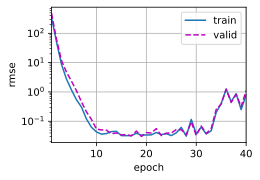

In [14]:
k, num_epochs, lr, weight_decay, batch_size = 2, 40, 0.01, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)

print(f'{k}-折验证: 平均训练rmse: {float(train_l):f}, '
      f'平均验证rmse: {float(valid_l):f}')

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 10, 0.01, 0, 64
net = get_net()
net.to(device)

In [12]:
train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size)

([array(3281.0164, dtype=float32),
  array(1358.0234, dtype=float32),
  array(1056.5244, dtype=float32),
  array(837.4972, dtype=float32),
  array(623.8247, dtype=float32),
  array(467.06357, dtype=float32),
  array(350.95804, dtype=float32),
  array(261.75003, dtype=float32),
  array(199.40263, dtype=float32),
  array(148.5642, dtype=float32)],
 [array(3281.0164, dtype=float32),
  array(1358.0234, dtype=float32),
  array(1056.5244, dtype=float32),
  array(837.4972, dtype=float32),
  array(623.8247, dtype=float32),
  array(467.06357, dtype=float32),
  array(350.95804, dtype=float32),
  array(261.75003, dtype=float32),
  array(199.40263, dtype=float32),
  array(148.5642, dtype=float32)])

In [13]:
label = net(test_features)

In [14]:
label - test_labels

tensor([[14.4837],
        [15.2950],
        [13.8367],
        ...,
        [ 9.9500],
        [ 7.8000],
        [ 9.6006]], grad_fn=<SubBackward0>)

In [15]:
re = torch.cat((test_labels, label, test_labels - label), 1)

In [16]:
re

tensor([[  0.2100,  14.6937, -14.4837],
        [  0.2200,  15.5150, -15.2950],
        [  0.2300,  14.0667, -13.8367],
        ...,
        [  0.7900,  10.7400,  -9.9500],
        [  0.7900,   8.5900,  -7.8000],
        [  0.7800,  10.3806,  -9.6006]], grad_fn=<CatBackward0>)

In [17]:
# 写入数据集
data_file = os.path.join('.', 'dataset', '0x01_50s_pre.csv')
with open(data_file, 'w') as f:
    for r in re:
        f.write(f'{r[0]},{r[1]},{r[2]}\n')

In [18]:
loss(net(test_features), test_labels)

tensor(148.5642, grad_fn=<MseLossBackward0>)